# Setup

In [1]:
import sys
path = "../../../.."
if path not in sys.path:
    sys.path.insert(0, path)

In [ ]:
from tqdm import tqdm
import random
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
from torchvision.models import resnet18, resnet50
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage.filters import gabor
from skimage.color import rgb2gray
from scipy.fft import fft2
import pywt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
epochs = 50
learningRate = 3e-4
extract = 5000
apply_prob = 0.3
dataset_path = "C:/Users/rapha/Documents/Cours/Master/Stage/coco/train2014"


# Données

## Données artificielles

In [ ]:
# === Degradations
from degradations.methods import transforms_atkinson_dithering, transforms_drawing, transforms_erased_element, transforms_paint, \
    transforms_cadre, transforms_encadre_rectangle, transforms_patchwork, transforms_photo_montage, transforms_picture_overlay, \
    transforms_text_overlay, transforms_text_around, transforms_cut_in_two, transforms_dirty_rollers, transforms_add_gaussian_noise, \
    transforms_add_salt_and_pepper_noise, transforms_bleedthrough, transforms_contrast, transforms_crumpled_paper, transforms_folded_paper, \
    transforms_ink_bleed, transforms_pliure_livre, transforms_stains, transforms_scribbles, transforms_torn_paper, transforms_blue, \
    transforms_faded

class transforms_SepiaFilter(nn.Module):
    def __init__(self):
        super().__init__()
    def __call__(self, batch):
        sepia_filter = torch.tensor([[0.393, 0.769, 0.189],
                                     [0.349, 0.686, 0.168],
                                     [0.272, 0.534, 0.131]], device=batch.device)
        batch = torch.einsum('ijkl,mj->imkl', batch, sepia_filter)
        return batch.clamp(0, 1)

labels = [
    "halftone", "drawing", "erased_element", "paint", "cadre_non_rectangulaire", "encadre_rectangle", "patchwork",
    "photo_montage", "picture_overlay", "text_overlay", "text_around", "cut_in_two", "dirty_rollers", "gaussian_noise",
    "salt_and_pepper_noise", "bleedthrough", "contrast", "crumpled_paper", 
    #"folded_paper", 
    "ink_bleed", "pliure_livre",
    "stains", "scribbles", "torn_paper", "blue", "faded", "sepia"
]

degradations = [
    transforms_atkinson_dithering(), transforms_drawing(), transforms_erased_element(), transforms_paint(),
    transforms_cadre(), transforms_encadre_rectangle(), transforms_patchwork(), transforms_photo_montage(),
    transforms_picture_overlay(), transforms_text_overlay(), transforms_text_around(), transforms_cut_in_two(),
    transforms_dirty_rollers(), transforms_add_gaussian_noise(), transforms_add_salt_and_pepper_noise(),
    transforms_bleedthrough(), transforms_contrast(), transforms_crumpled_paper(), 
    #transforms_folded_paper(),
    transforms_ink_bleed(), transforms_pliure_livre(), transforms_stains(), transforms_scribbles(),
    transforms_torn_paper(), transforms_blue(), transforms_faded(), transforms_SepiaFilter()
]

all_degradations = list(zip(labels, degradations))
assert len(all_degradations) == 26 #27

# === Transforms
base_transform = T.Compose([T.Resize((256, 256)), T.ToTensor()])

# === Chargement des images
base_images = [Image.open(p).convert("RGB") for p in glob.glob(dataset_path + "/*.jpg")[:extract]]
print(f"{len(base_images)} base images loaded")

# === Datasets
class OneLabelDegradationDataset(Dataset):
    def __init__(self, base_images, image_transform=None):
        self.base_images = base_images
        self.image_transform = image_transform
        self.degradations = all_degradations

    def __len__(self):
        return len(self.base_images)

    def __getitem__(self, idx):
        image = self.base_images[idx].copy()
        if self.image_transform:
            image = self.image_transform(image)
        label_idx = random.randint(0, len(self.degradations) - 1)
        label = [0] * len(self.degradations)
        label[label_idx] = 1
        _, fn = self.degradations[label_idx]
        try:
            image = fn(image.unsqueeze(0)).squeeze()
        except Exception as e:
            print(f"Erreur dans OneLabel: ({self.degradations[label_idx]}) {e}")
        return image, torch.tensor(label).float()

class MultiLabelDegradationDataset(Dataset):
    def __init__(self, base_images, apply_prob=0.3, image_transform=None):
        self.base_images = base_images
        self.image_transform = image_transform
        self.degradations = all_degradations
        self.apply_prob = apply_prob

    def __len__(self):
        return len(self.base_images)

    def __getitem__(self, idx):
        image = self.base_images[idx].copy()
        if self.image_transform:
            image = self.image_transform(image)
        label = [0] * len(self.degradations)
        for i, (_, fn) in enumerate(self.degradations):
            if random.random() < self.apply_prob:
                try:
                    image = fn(image.unsqueeze(0)).squeeze()
                    label[i] = 1
                except Exception as e:
                    print(f"Erreur dans MultiLabel: {e}")
        return image, torch.tensor(label).float()
    


In [4]:
# Mono-degradation dataset
one_ds = OneLabelDegradationDataset(base_images, base_transform)
train1, test1 = random_split(one_ds, [int(0.8 * len(one_ds)), len(one_ds) - int(0.8 * len(one_ds))])
trainLoader1 = DataLoader(train1, batch_size=batch_size, shuffle=True, num_workers=4)
testLoader1 = DataLoader(test1, batch_size=batch_size, shuffle=False, num_workers=4)

# Multi-degradation dataset
multi_ds = MultiLabelDegradationDataset(base_images, apply_prob=apply_prob, image_transform=base_transform)
train2, test2 = random_split(multi_ds, [int(0.8 * len(multi_ds)), len(multi_ds) - int(0.8 * len(multi_ds))])
trainLoader2 = DataLoader(train2, batch_size=batch_size, shuffle=True, num_workers=4)
testLoader2 = DataLoader(test2, batch_size=batch_size, shuffle=False, num_workers=4)

## Données réelles

In [ ]:
df = pd.read_csv('annotations_clean.csv', sep=",", engine='python',quotechar='"')  

labels_ann = [
    "halftone", "drawing", "erased_element", "paint", "non_rectangular_frame", "rectangular_frame", "patchwork",
    "photo_montage", "picture_overlay", "text_overlay", "text_around", "cut_in_two", "dirty_rollers", "gaussian_noise",
    "salt_and_pepper_noise", "bleedthrough", "contrast", "crumpled_paper", 
    #"folded_paper", 
    "ink_bleed", "book",
    "stains", "scribbles", "torn_paper", "blue", "faded", "sepia"
]


for label in labels_ann:
    df[label] = df['labels'].apply(lambda x: 1 if label in x.split(',') else 0)

df = df.drop('labels', axis=1)
df.columns = ['image', *labels]

images_list = df['image'].tolist()
label_list = df.drop(columns=['image']).values.tolist()
y = np.array(label_list) # labels

In [ ]:
base_transform = T.Compose([T.Resize((256, 256)), T.ToTensor()])
path_unique = "C:/Users/rapha/Documents/Cours/Master/Stage/HighVision/corpus/lipade_groundtruth/unique/"
path_similar = "C:/Users/rapha/Documents/Cours/Master/Stage/HighVision/corpus/lipade_groundtruth/similar/"

# === Chargement des images
base_images_real = []
for p in tqdm(images_list):
    try :
        img = Image.open(path_unique+p).convert("RGB")

    except FileNotFoundError  as e:
        img = Image.open(path_similar+p).convert("RGB")
    base_images_real.append(base_transform(img))

print(f"{len(base_images_real)} base images loaded")


100%|██████████| 503/503 [00:42<00:00, 11.72it/s]

503 base images loaded


In [ ]:
# import pickle

# with open('y.pkl', 'rb') as f:
#     y = pickle.load(f)
# y = torch.tensor(y)


class RealDegradationDataset(Dataset):
    def __init__(self, base_images, labels, image_transform=None):
        self.base_images = base_images
        self.image_transform = image_transform
        self.labels = labels

    def __len__(self):
        return len(self.base_images)

    def __getitem__(self, idx):
        image = self.base_images[idx]
        if self.image_transform:
            image = self.image_transform(image)
        label = self.labels[idx]

        return image, torch.tensor(label).float()


real_ds = RealDegradationDataset(base_images_real, y)
train3, test3 = random_split(real_ds, [int(0.8 * len(real_ds)), len(real_ds) - int(0.8 * len(real_ds))])
trainLoader3 = DataLoader(train3, batch_size=batch_size, shuffle=True)
testLoader3 = DataLoader(test3, batch_size=batch_size, shuffle=False)

# Avec deep

In [5]:
# === Modele
class DegradationClassifier(nn.Module):
    def __init__(self, n_labels=27, dropout_p=0.5, in_features=512):
        super().__init__()
        model = resnet18(pretrained=True)
        model.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(512, n_labels),
            )
        self.model = model

    def forward(self, x):
        return torch.sigmoid(self.model(x))

# === Metrics multilabel
def multi_label_accuracy(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred > threshold).float()
    correct = (y_pred == y_true).float()
    return correct.sum() / correct.numel()

def compute_metrics_all(outputs, labels, threshold=0.5):
    """
    Calcule precision, recall, F1 pour un batch global de predictions et labels.
    """
    preds = (outputs > threshold).int().cpu().numpy()
    trues = labels.int().cpu().numpy()
    precision = precision_score(trues, preds, average='macro', zero_division=0)
    recall = recall_score(trues, preds, average='macro', zero_division=0)
    f1 = f1_score(trues, preds, average='macro', zero_division=0)
    return precision, recall, f1

# === Entrainement generique (retourne liste des losses)
def train_classifier(model, trainLoader, name):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learningRate)
    criterion = nn.BCELoss()
    writer = SummaryWriter(log_dir=f"logs/{name}")
    losses_per_epoch = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for x, y in tqdm(trainLoader, desc=f"[{name}] Epoch {epoch}"):
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = criterion(preds, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(trainLoader)
        losses_per_epoch.append(avg_loss)
        writer.add_scalar("Loss/train", avg_loss, epoch)

    torch.save(model.state_dict(), f"{name}.pth")
    return losses_per_epoch

def evaluate_classifier(model, testLoader):
    model.eval()
    all_outputs = []
    all_labels = []
    with torch.no_grad():

        for x, y in testLoader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            all_outputs.append(preds)
            all_labels.append(y)

    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    acc = multi_label_accuracy(all_outputs, all_labels).item()
    precision, recall, f1 = compute_metrics_all(all_outputs, all_labels)
    return acc, precision, recall, f1


## Sur données artificielles

In [ ]:

# === Phase 1 : prétraining avec 1 dégradation
print("\n=== Étape 1: Mono-dégradation ===")
model = DegradationClassifier()
losses1 = train_classifier(model, trainLoader1, "degrad_step1_single")
acc1, prec1, rec1, f1_1 = evaluate_classifier(model, testLoader1)
print(f"[Phase 1] Accuracy: {acc1:.4f}, Precision: {prec1:.4f}, Recall: {rec1:.4f}, F1: {f1_1:.4f}")

# Trace et enregistre la courbe de loss de la phase 1
plt.figure()
plt.plot(range(1, epochs+1), losses1, marker='o')
plt.title("Phase 1 - Loss (Mono-dégradation)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("loss_degrad_step1_single.png")
plt.close()

# === Phase 2 : fine-tuning multilabel
print("\n=== Étape 2: Multi-dégradations ===")
# Charge le modèle pré-entraîné de la phase 1
model.load_state_dict(torch.load("degrad_step1_single.pth"))
losses2 = train_classifier(model, trainLoader2, "degrad_step2_multi")
acc2, prec2, rec2, f1_2 = evaluate_classifier(model, testLoader2)
print(f"[Phase 2] Accuracy: {acc2:.4f}, Precision: {prec2:.4f}, Recall: {rec2:.4f}, F1: {f1_2:.4f}")

# Trace et enregistre la courbe de loss de la phase 2
plt.figure()
plt.plot(range(1, epochs+1), losses2, marker='o')
plt.title("Phase 2 - Loss (Multi-dégradations)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("loss_degrad_step2_multi.png")
plt.close()

## Sur données réelles

In [ ]:
model.eval()
all_outputs = []
all_labels = []
with torch.no_grad():
    for x, y in zip(base_images_real, y):
        x, y = x.to(device), y.to(device)
        preds = model(x)
        all_outputs.append(preds)
        all_labels.append(y)


all_outputs = torch.cat(all_outputs, dim=0)
all_labels = torch.cat(all_labels, dim=0)
acc = multi_label_accuracy(all_outputs, all_labels).item()
precision, recall, f1 = compute_metrics_all(all_outputs, all_labels)


print(f"[Phase 2 (real)] Accuracy: {acc2:.4f}, Precision: {prec2:.4f}, Recall: {rec2:.4f}, F1: {f1_2:.4f}")

In [ ]:
losses3 = train_classifier(model, trainLoader3, "degrad_step3_real")
acc3, prec3, rec3, f1_3 = evaluate_classifier(model, testLoader3)
print(f"[Phase 3] Accuracy: {acc3:.4f}, Precision: {prec3:.4f}, Recall: {rec3:.4f}, F1: {f1_3:.4f}")

Affichage des prédictions :

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def show_predictions(model, dataloader, label_names, device, n_images=12, n_cols=4, threshold=0.5):
    model.eval()
    images_shown = 0
    n_rows = (n_images + n_cols - 1) // n_cols  # arrondi au-dessus

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
    axes = axes.flatten()  # pour accès simple

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = (outputs > threshold).float()

            for i in range(images.size(0)):
                if images_shown >= n_images:
                    break

                img = images[i].cpu()
                true_labels = [label_names[j] for j in range(len(label_names)) if labels[i][j] == 1]
                pred_labels = [label_names[j] for j in range(len(label_names)) if preds[i][j] == 1]

                ax = axes[images_shown]
                ax.imshow(F.to_pil_image(img))
                ax.set_title(
                    f"Vrai: {', '.join(true_labels)}\nPrévu: {', '.join(pred_labels)}",
                    fontsize=8
                )
                ax.axis("off")

                images_shown += 1

            if images_shown >= n_images:
                break

    # Masque les axes inutilisés
    for j in range(images_shown, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
show_predictions(model, testLoader3, labels, device=device, n_images=25, n_cols=5, threshold=0.5)

# Sans deep

In [ ]:
def extract_features(image):
    image_gray = rgb2gray(image)
    features = []

    # 1. LBP
    lbp = local_binary_pattern(image_gray, P=8, R=1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)
    features.extend(hist)

    # 2. GLCM
    glcm = graycomatrix((image_gray * 255).astype('uint8'), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    for prop in ['contrast', 'homogeneity', 'energy', 'ASM']:
        features.append(graycoprops(glcm, prop)[0, 0])

    # 3. Gabor filter 

    orientations = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    frequencies = [0.1, 0.2, 0.3, 0.4]
    for theta in orientations:
        for f in frequencies:
            filt_real, filt_imag = gabor(image_gray, frequency=f, theta=theta)
            features.extend([filt_real.mean(), filt_real.var()])

    # 4. FFT
    fft_img = np.abs(fft2(image_gray))
    features.extend([np.mean(fft_img), np.var(fft_img)])

    # 5. Wavelet (DWT - Haar)
    coeffs2 = pywt.dwt2(image_gray, 'haar')
    cA, (cH, cV, cD) = coeffs2
    for comp in [cA, cH, cV, cD]:
        features.extend([np.mean(comp), np.var(comp)])

    return np.array(features)


## Corrélation

100%|██████████| 26/26 [38:26<00:00, 88.73s/it]   


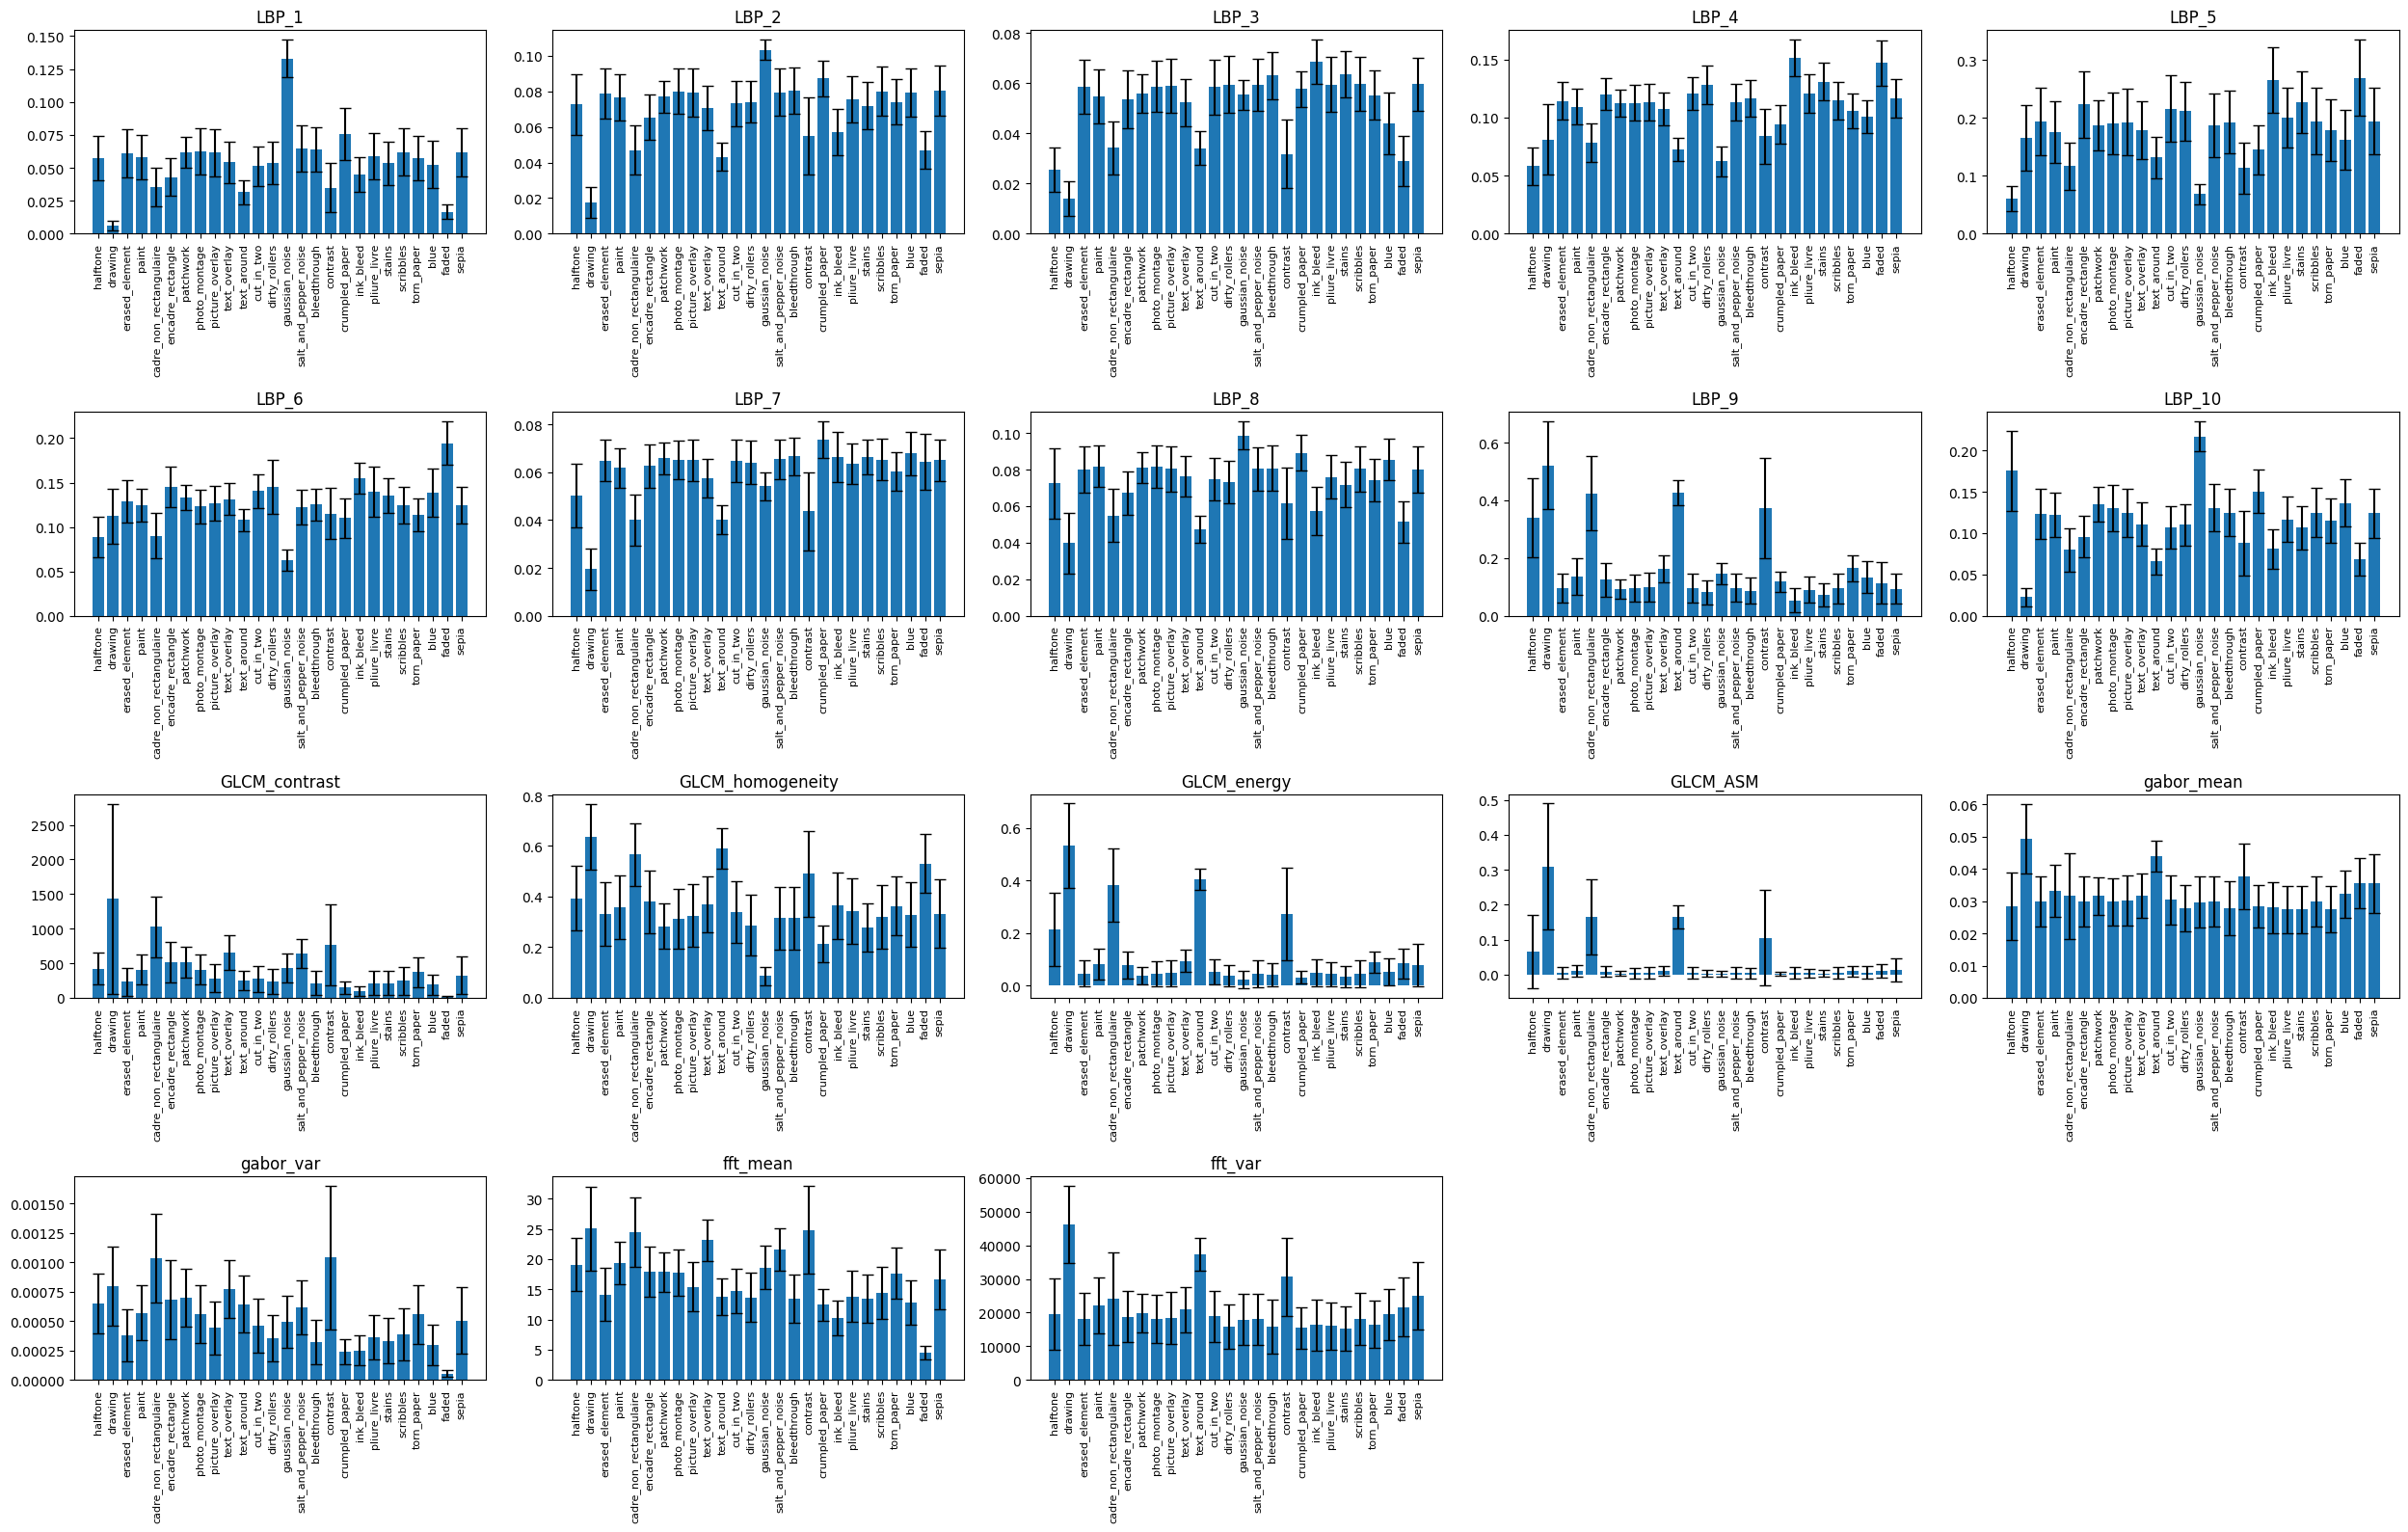

In [6]:
import os
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage.filters import gabor
from numpy.fft import fft2

from torchvision import transforms as T


# === Prétraitement
transform_tensor = T.Compose([T.Resize((256, 256)), T.ToTensor()])

# === Fonction d’extraction des features
def extract_features(image):
    image_gray = rgb2gray(image)
    features = []

    # LBP
    lbp = local_binary_pattern(image_gray, P=8, R=1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)
    features.extend(hist)

    # GLCM
    glcm = graycomatrix((image_gray * 255).astype('uint8'), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    for prop in ['contrast', 'homogeneity', 'energy', 'ASM']:
        features.append(graycoprops(glcm, prop)[0, 0])

    # Gabor
    filt_real, _ = gabor(image_gray, frequency=0.6)
    features.extend([filt_real.mean(), filt_real.var()])

    # FFT
    fft_img = np.abs(fft2(image_gray))
    features.extend([np.mean(fft_img), np.var(fft_img)])

    return np.array(features)

# === Boucle principale
def compare_features_all(base_images, n_images=5):
    names_features = ["LBP_1", "LBP_2","LBP_3","LBP_4", "LBP_5", "LBP_6","LBP_7","LBP_8", "LBP_9", "LBP_10",
                       "GLCM_contrast", "GLCM_homogeneity", "GLCM_energy", "GLCM_ASM", "gabor_mean", "gabor_var", "fft_mean", "fft_var"]
    all_means = []
    all_stds = []

    for degr, name in tqdm(zip(degradations, labels), total=len(degradations)):
        feats = []
        for img in base_images[:n_images]:
            try:
                img_tensor = transform_tensor(img).unsqueeze(0)
                degraded = degr(img_tensor).squeeze(0).permute(1, 2, 0).cpu().numpy()
                feats.append(extract_features(degraded))
            except Exception as e:
                print(f"[Erreur] {path}: {e}")
        feats = np.array(feats)
        all_means.append(feats.mean(axis=0))
        all_stds.append(feats.std(axis=0))

    all_means = np.array(all_means)  # [27, nb_features]
    all_stds = np.array(all_stds)

    n_features = all_means.shape[1]
    n_cols = 5
    n_rows = int(np.ceil(n_features / n_cols))

    # === Visualisation multi-subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axs = axs.flatten()

    for i in range(n_features):
        axs[i].bar(np.arange(len(labels)), all_means[:, i], yerr=all_stds[:, i], capsize=4)
        axs[i].set_title(f"{names_features[i]}")
        axs[i].set_xticks(np.arange(len(labels)))
        axs[i].set_xticklabels(labels, rotation=90, fontsize=8)

    for j in range(n_features, len(axs)):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()


compare_features_all(base_images, 200)

In [7]:
import seaborn as sns
from sklearn.feature_selection import f_classif

transform_tensor = T.Compose([T.Resize((256, 256)), T.ToTensor()])
# Corrélation via F-score ANOVA
X = []
y = []
for i, degrad in enumerate(degradations):
    for img in base_images:
        img_tensor = transform_tensor(img).unsqueeze(0)
        degraded = degrad(img_tensor).squeeze(0).permute(1, 2, 0).cpu().numpy()
        X.append(extract_features(degraded))
        y.append(i)

X = np.array(X)
y = np.array(y)

# F-statistic corrélation
f_scores, _ = f_classif(X, y)
plt.figure(figsize=(12, 1.5))
sns.heatmap([f_scores], cmap='viridis', xticklabels=["LBP", "LBP","LBP","LBP", "LBP", "LBP","LBP","LBP", "LBP", "LBP",
                       "GLCM_c", "GLCM_h", "GLCM_e", "GLCM_ASM", "gabor_m", "gabor_v", "fft_m", "fft_v"], yticklabels=['F-score'])
plt.title('F-score ANOVA entre caractéristiques et classes de dégradations')
plt.show()

## Train

In [27]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


X_train = []
y_train = []
for x, y in train1:
    img = x.numpy().transpose(1, 2, 0) *255
    img = img.astype(np.uint8)
    caract = extract_features(img)
    X_train.append(caract)
    y_train.append(y.numpy())


X_test = []
y_test = []
for x, y in test1:
    img = x.numpy().transpose(1, 2, 0) *255
    img = img.astype(np.uint8)
    X_test.append(extract_features(img))
    y_test.append(y.numpy())

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = OneVsRestClassifier(make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True)))
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 (macro):", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))


Accuracy: 0.21
Precision (macro): 0.26282051282051283
Recall (macro): 0.16826923076923078
F1 (macro): 0.19304029304029305
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       1.00      0.67      0.80         3
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       1.00      0.17      0.29         6
           5       0.00      0.00      0.00         4
           6       1.00      0.33      0.50         3
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         1
          10       0.83      0.83      0.83         6
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         7
          13       1.00      0.88      0.93         8
          14       0.00      0.00      0.00         5
          15 

# Extraction de caractéristiques avec deep

In [ ]:
import cv2
def extract_filter_maps(image):
    image_gray = rgb2gray(image)
    filter_maps = []
    # 1. LBP
    lbp = local_binary_pattern(image_gray, P=8, R=1, method='uniform')
    filter_maps.append(lbp)

    # 2. GLCM
    # glcm = graycomatrix((image_gray * 255).astype('uint8'), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    # for prop in ['contrast', 'homogeneity', 'energy', 'ASM']:
    #     features.append(graycoprops(glcm, prop)[0, 0])

    # 3. Gabor filter
    orientations = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    frequencies = [0.1, 0.2, 0.3, 0.4]
    for theta in orientations:
        for f in frequencies:
            filt_real, _ = gabor(image_gray, frequency=f, theta=theta)
            filter_maps.append(filt_real)
            
    # 4. FFT
    fft = np.abs(fft2(image_gray))
    filter_maps.append(fft)

    # 5. Wavelet (DWT - Haar)
    coeffs2 = pywt.dwt2(image_gray, 'haar')
    cA, (cH, cV, cD) = coeffs2
    for comp in [cA, cH, cV, cD]:
        filter_maps.append(comp)

    filter_maps = [cv2.resize(m, (256, 256)) for m in filter_maps]  # Resize si besoin
    filter_maps = [(m - np.min(m)) / (np.max(m) - np.min(m) + 1e-6) for m in filter_maps]
    filter_maps = np.stack(filter_maps, axis=0)
    input_tensor = torch.tensor(filter_maps, dtype=torch.float32).unsqueeze(0) 
    return input_tensor



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class FilterCNN(nn.Module):
    def __init__(self, in_channels, num_labels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),  # output: (B, 128, 1, 1)
        )
        self.fc = nn.Linear(128, num_labels)

    def forward(self, x):
        x = self.conv(x)              # (B, 128, 1, 1)
        x = x.view(x.size(0), -1)     # (B, 128)
        x = self.fc(x)                # (B, num_labels)
        return x                      # raw logits


In [ ]:
class FilterMapDataset_OneLabel(torch.utils.data.Dataset):
    def __init__(self, base_images):
        self.base_images = base_images
        self.degradations = all_degradations

    def __len__(self):
        return len(self.base_images)

    def __getitem__(self, idx):
        image = self.base_images[idx].copy()
        label_idx = random.randint(0, len(self.degradations) - 1)
        label = [0] * len(self.degradations)
        label[label_idx] = 1
        _, fn = self.degradations[label_idx]
        image = fn(image.unsqueeze(0)).squeeze()

        
        image = image.numpy().transpose(1, 2, 0) *255
        image = image.astype(np.uint8)
    
        maps = extract_filter_maps(image)  # shape (C, H, W)
        maps_tensor = torch.tensor(maps, dtype=torch.float32)
        label_tensor = torch.tensor(label).float()
        return maps_tensor, label_tensor


In [ ]:
from torch.utils.data import DataLoader

model = FilterCNN(in_channels=22, num_labels=26) 
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_dataset = FilterMapDataset_OneLabel(base_images)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

model.train()
for epoch in range(10):
    total_loss = 0
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


In [ ]:
model.eval()
with torch.no_grad():
    for inputs, _ in train_loader:
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)       # Convertir logits en proba
        preds = (probs > 0.5).int()          # Binarisation
        break
